**DA5401: Assignment 7**

*Multi-Class Model Selection using ROC and Precision-Recall Curves*

**Problem Statement:**

Utilise ROC and PRC to perform model selection for the multi-class classification problem on the UCI Landsat Satellite dataset. Determine the best and worst performing models across different decision threshoolds using adaptations for the model selection methods to work on the multi-class classification problem (such as one-vs-rest averaging).

**Imports**

In [56]:
# necessities
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

# models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.base import BaseEstimator, ClassifierMixin

# metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.metrics import precision_recall_curve, average_precision_score

# sklearn necessities
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler, label_binarize, LabelEncoder

## Part A: Data Preparation and Baseline

Load and Prepare Data

In [57]:
# Loading data from the files extracted from the zip

ext = ['trn', 'tst']
train_data = []
test_data = []
for e in ext:
    fname = f'sat.{e}'
    with open(fname, 'r') as f:
        for line in f:
            if e == 'trn':
                train_data.append([np.float64(x) for x in line.split()])
            else:
                test_data.append([np.float64(x) for x in line.split()])
    f.close()

print(f'{len(train_data)} Train Samples Loaded')          
print(f'{len(test_data)} Test Samples Loaded')  

train_np = np.array(train_data)  
test_np = np.array(test_data)
X_train, y_train = train_np[:, :-1], train_np[:, -1].astype(np.int64)
X_test, y_test = test_np[:, :-1], test_np[:, -1].astype(np.int64)

print(f'Shape of Train Data: {X_train.shape} and labels: {y_train.shape}')
print(f'Shape of Test Data: {X_test.shape} and labels: {y_test.shape}')

labels_dict = {'1': 'red soil', '2': 'cotton crop', '3': 'grey soil',
                '4': 'damp grey soil', '5': 'soil with vegetation stubble', '7': 'very damp grey soil'}
colors = sns.color_palette('colorblind', 9)

4435 Train Samples Loaded
2000 Test Samples Loaded
Shape of Train Data: (4435, 36) and labels: (4435,)
Shape of Test Data: (2000, 36) and labels: (2000,)


In [58]:
# Standard Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Train/Test Split

In [59]:
# As the .zip file already provides different train and test datasets, this step is skipped
# Additionally, as mentioned in the assignment, the class label 6, which was to be ignored, is already absent in the data provided in the .zip
# As such, no preprocessing needs to be done either. The dataset has no null values

Class Distribution

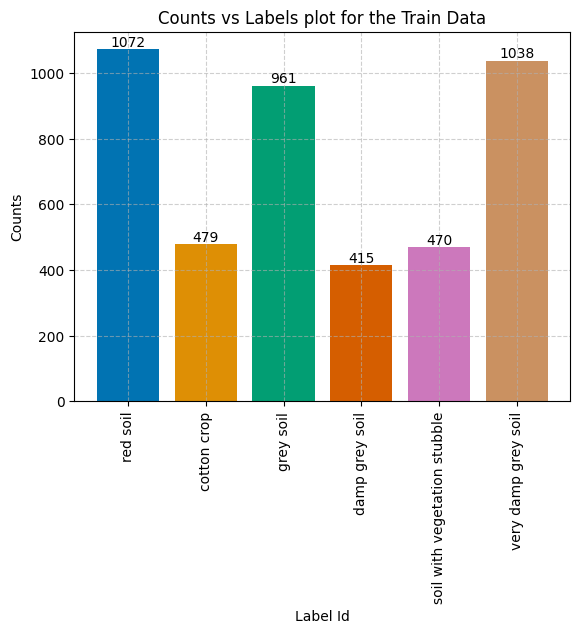

In [60]:
labels, counts = np.unique(y_train, return_counts= True)
fig, ax = plt.subplots()
bars = ax.bar(labels_dict.values(), counts, color= colors)
ax.bar_label(bars)
plt.grid(True, alpha= 0.6, linestyle= '--')
plt.ylabel('Counts')
plt.xlabel('Label Id')
plt.xticks(rotation= 90)
plt.title('Counts vs Labels plot for the Train Data')
plt.show()

### Training All Models

In [61]:
class BadClassifier(BaseEstimator, ClassifierMixin):
    """
    A KNN Classifier which returns the opposite of what's correct
    Should cause AUC < 0.5
    """
    def __init__(self):
        self._clf = KNeighborsClassifier()

    def fit(self, X, y):
        self._clf.fit(X, y)
        self.classes_ = self._clf.classes_
        return self

    def predict_proba(self, X):
        p = self._clf.predict_proba(X)
        p_inv = 1. - p
        # Rennormalise the inverted probabilities
        p_inv = p_inv/p_inv.sum(axis=1, keepdims= True)
        return p_inv

    def predict(self, X):
        return self.classes_[np.argmax(self.predict_proba(X), axis= 1)]

In [62]:
# Setting up models

models = {
    "KNN": KNeighborsClassifier(),
    "DecisionTree": DecisionTreeClassifier(random_state= 42),
    "Dummy": DummyClassifier(random_state= 42, strategy= 'prior'),
    "NaiveBayes": GaussianNB(),
    "LogisticRegression": LogisticRegression(random_state= 42),
    "SVM": SVC(probability=True, random_state= 42, decision_function_shape= 'ovr'),
    "RandomForest": RandomForestClassifier(random_state= 42),
    "Bad": BadClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', verbosity=0, random_state= 42),
}

# Setting up param_grids
param_grids = {
    "KNN": {'n_neighbors': [1, 3, 5], 'p': [1, 2], 'weights': ['uniform', 'distance']},
    "DecisionTree": {'criterion': ['gini', 'entropy', 'logloss'], 'max_depth': [10, 50, None]},
    "Dummy": {},
    "NaiveBayes": {},
    "LogisticRegression": {'penalty': ['l1', 'l2', 'elasticnet'], 'C': [1, 10, 0.1], 'solver': ['saga', 'lbfgs'], 'max_iter': [100, 500, 1000]},
    "SVM": {'C': [1, 10, 0.1], 'kernel': ['rbf', 'linear']},
    "RandomForest": {'n_estimators': [100, 200, 500], 'criterion': ['gini', 'entropy', 'log_loss'], 'max_depth': [10, 50, None]},
    "Bad": {}, 
    "XGBoost": {'n_estimators': [100, 200, 500], 'max_depth': [10, 50, None], 'learning_rate': [0.1, 1, 0.01], }
}

# For XGBoost
le_xgb = LabelEncoder()
y_train_xgb = le_xgb.fit_transform(y_train)
y_test_xgb = le_xgb.transform(y_test)

Setting up grid search. Takes about 3 mins on the base grid.

Uncomment the lines in the code section below to run

In [63]:
# best_params = dict()
# for name, model in tqdm(models.items(), desc= 'Grid Search Progress'):
#     tqdm.write(f'Current model: {name}')
#     gs = GridSearchCV(model, param_grids[name], cv=3, n_jobs=-1)
#     y_fit = y_train if name != 'XGBoost' else y_train_xgb
#     gs.fit(X_train, y_fit)
#     tqdm.write(f'Best params for {name}: {gs.best_params_}')
#     best_params[name] = gs.best_params_

In [64]:
# Setting up best models after grid-search to prevent re-runs
# print(best_params)
models = {
    "KNN": KNeighborsClassifier(n_neighbors= 5, p= 1, weights= 'uniform'),
    "DecisionTree": DecisionTreeClassifier(random_state= 42, criterion= 'entropy', max_depth= 10),
    "Dummy": DummyClassifier(random_state= 42, strategy= 'prior'),
    "NaiveBayes": GaussianNB(),
    "LogisticRegression": LogisticRegression(random_state= 42, C= 1, penalty= 'l2', solver= 'saga', max_iter= 100),
    "SVM": SVC(probability=True, random_state= 42, decision_function_shape= 'ovr', C= 1, kernel= 'rbf'),
    "RandomForest": RandomForestClassifier(random_state= 42, criterion= 'gini', max_depth= 50, n_estimators= 200),
    "Bad": BadClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', verbosity=0, random_state= 42,
                             learning_rate= 1, max_depth= None, n_estimators= 500),
}

In [65]:
results = []
trained_models = dict()
n_classes = len(labels)
y_test_bin = label_binarize(y_test, classes=labels)

for name, model in tqdm(models.items(), desc="Models Trained"):
    tqdm.write(f'Current Model: {name}')
    clf = OneVsRestClassifier(model)
    clf.fit(X_train, y_train)
    
    # Predictions and Scores
    if hasattr(clf, "predict_proba"):
        y_score = clf.predict_proba(X_test)
    else:
        y_score = clf.decision_function(X_test)
    
    y_pred = clf.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    auc_macro = roc_auc_score(y_test_bin, y_score, average='macro', multi_class='ovr')
    ap_macro = average_precision_score(y_test_bin, y_score, average='macro')
    
    results.append({
        "Model": name,
        "Accuracy": acc,
        "F1-Score": f1,
        "ROC-AUC (macro)": auc_macro,
        "PR-AUC (macro)": ap_macro
    })

    trained_models[name] = clf

print('Training completed')

Models Trained:   0%|          | 0/9 [00:00<?, ?it/s]

Current Model: KNN
Current Model: DecisionTree
Current Model: Dummy
Current Model: NaiveBayes
Current Model: LogisticRegression


/home/devashish623/devashish/defvenv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/devashish623/devashish/defvenv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/devashish623/devashish/defvenv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/devashish623/devashish/defvenv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/devashish623/devashish/defvenv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.w

Current Model: SVM
Current Model: RandomForest
Current Model: Bad
Current Model: XGBoost
Training completed


### Baseline Evaluation

In [66]:
results_df = pd.DataFrame(results).sort_values(by="F1-Score", ascending=False)
print("Model Comparison Table (Testing) (Sorted with best F1-Score on top):")
print(results_df.to_string(index=False))

Model Comparison Table (Testing) (Sorted with best F1-Score on top):
             Model  Accuracy  F1-Score  ROC-AUC (macro)  PR-AUC (macro)
      RandomForest    0.9040  0.901377         0.990159        0.952194
               KNN    0.9010  0.900524         0.977779        0.920575
           XGBoost    0.9005  0.898898         0.983971        0.932795
               SVM    0.8910  0.886662         0.983314        0.910070
      DecisionTree    0.8510  0.850846         0.936659        0.826382
        NaiveBayes    0.8010  0.802902         0.937400        0.728161
LogisticRegression    0.8205  0.792476         0.953972        0.812282
             Dummy    0.2305  0.086356         0.500000        0.166667
               Bad    0.0105  0.006253         0.021750        0.133013


**Model Performance Evaluation**

*Most models perform well with the exception of the Dummy Classifier(which returns the most common class label due to the 'prior' strategy used) and the Bad Classifier(which is intended to perform bad by inverting the output of the KNN Classifier)*

*Among the well-performing models, Logistic Regression performs relatively bad, with the F1-score slightly below 80, which might be due to the simplistic nature of the model and its assumption that the data can be modeled using linearity assumption, where it is known that the data is heavily non-linear. NaiveBayes performs surprisingly well for a complex dataset, as it assumes feature independence. This indicates that the feature independence assumption was enough to model the data. However, it scores the worst AUC-PR (not counting Dummy and Bad), indicating that this assumption is not enough for confident prediction. A change in the decision threshold could showcase more knowledge about the Naive Bayes performance.*

*DecisionTree and SVM perform as expected, with slightly better performace. As decision trees are prone to overfitting, their PR-AUC remains comparatively low. KNN surprisingly performs great, which might indicate that the dataset has all the classes clustered close.*

*RandomForest provides the best results in all parameters, making full use of the ensemble of decision trees to take the decision to make generalized decision. XGBoost, despite its learning power, lags behind, with a lower F1-score than even KNN, although performing better than it in rest of the cases. This indicates that it has learnt the space well, even if it scores lower than the ensemble RandomForest and thus, is also a good choice.*

## Part B: ROC Analysis for Model Selection

### Multi-Class ROC Calculation


**How is the One-vs-Rest(OvR) approach used to generate ROC curves and calculate the Area Under the Curve(AUC) in a multi-class setting?**

*The ROC curve plots the True Positive Rate against the False Positive Rate. A point on curve represents a threshold, where the best classifier is close to the top-left while the worst follows a random-classifier's line. Higher AUC means better performance. It measures how well the model weighs the correct class label (class ranking), indicated by an increase in AUC if the correct label is weighed higher and decrease otherwise.*

*In multi-class cases, OvR is used to generate RoC by taking each class as positive while the rest remain negative. ROC and AUC are calculated class-wise separately and averaging can be done to get the model AUC*

### Plotting ROC

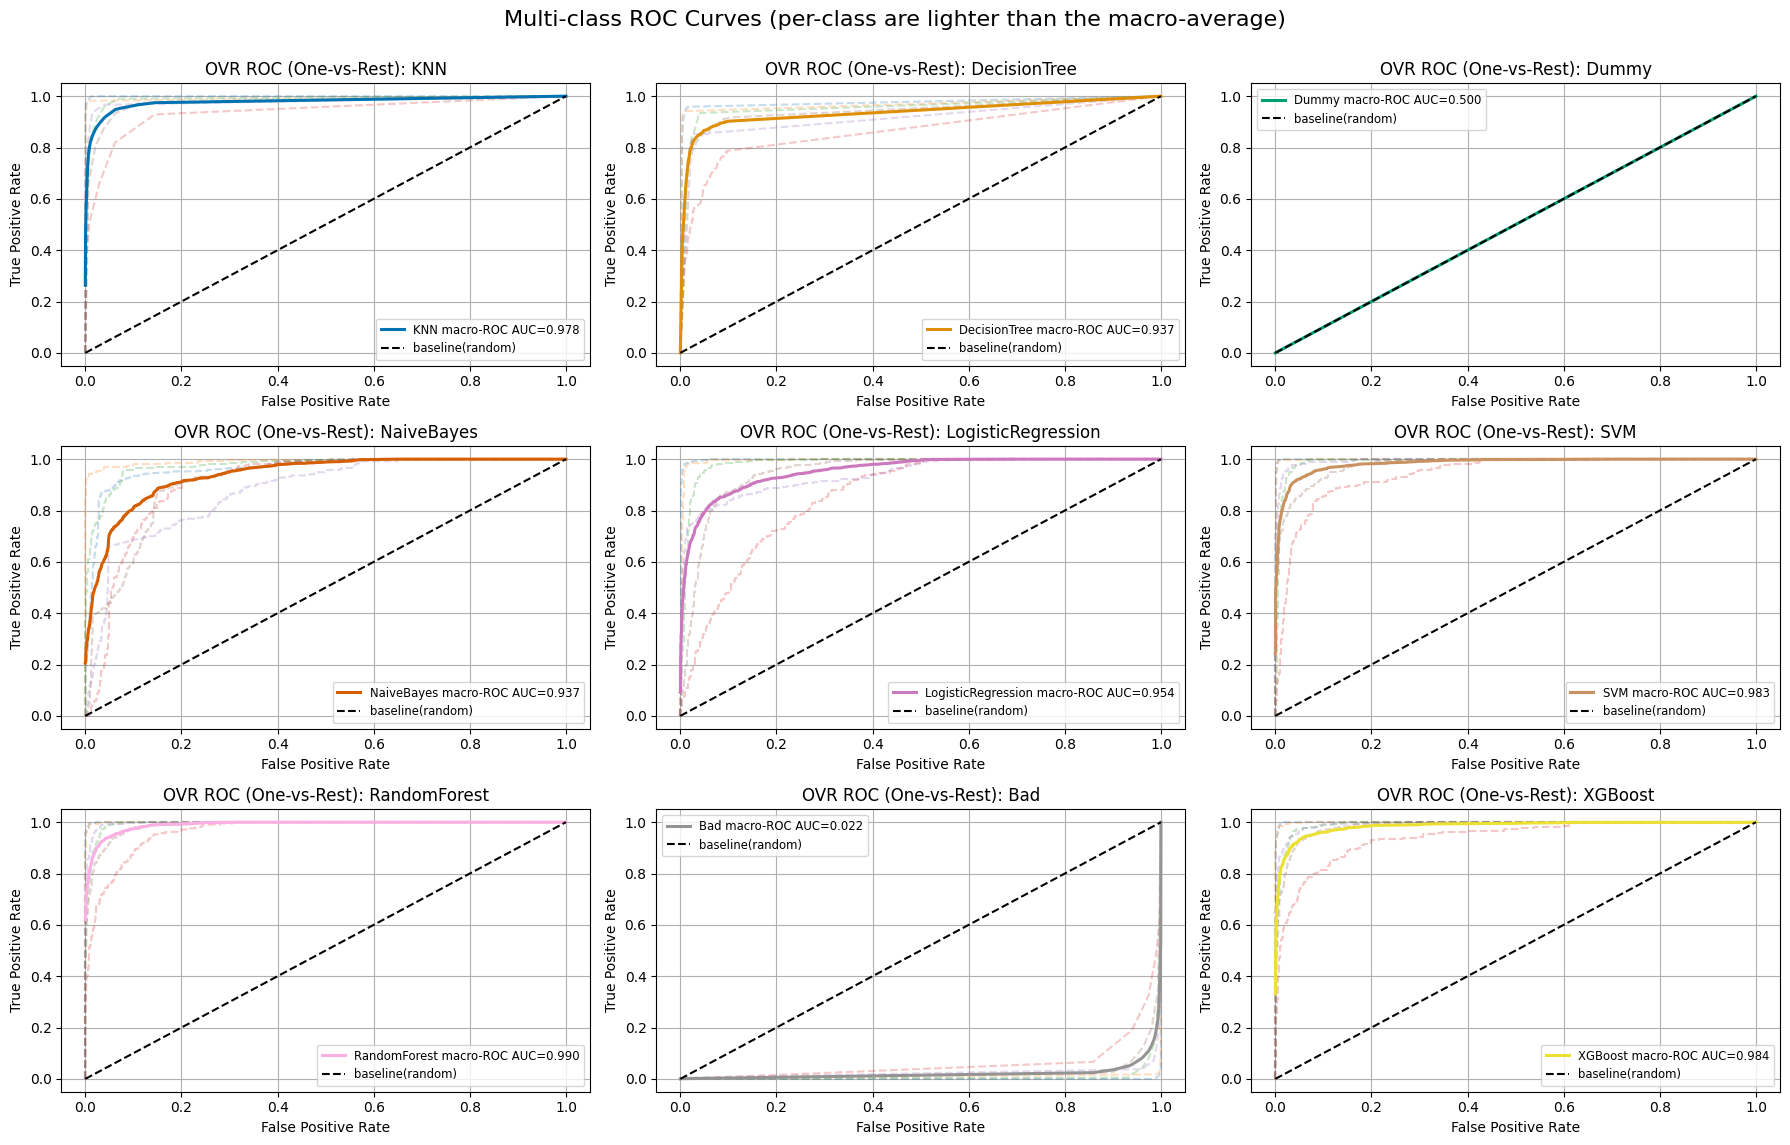

In [67]:
fig, axs = plt.subplots(3, 3, figsize=(18, 12))
axs = axs.flatten()

for idx, (name, model) in enumerate(trained_models.items()):
    ax = axs[idx]

    if hasattr(model, "predict_proba"):
        scores = model.predict_proba(X_test)
    else:
        scores = model.decision_function(X_test)
        if scores.ndim == 1:
            scores = np.vstack([-scores, scores]).T

    fprs, tprs, aucs = {}, {}, {}
    all_fpr = np.unique(
        np.concatenate([roc_curve(y_test_bin[:, i], scores[:, i])[0] for i in range(n_classes)])
    )
    mean_tpr = np.zeros_like(all_fpr)

    for i in range(n_classes):
        fpr_i, tpr_i, _ = roc_curve(y_test_bin[:, i], scores[:, i])
        fprs[i], tprs[i] = fpr_i, tpr_i
        aucs[i] = auc(fpr_i, tpr_i)
        mean_tpr += np.interp(all_fpr, fpr_i, tpr_i)

    mean_tpr /= n_classes
    macro_auc = np.mean(list(aucs.values()))

    # Class-wise AUC
    for i in range(n_classes):
        ax.plot(fprs[i], tprs[i], alpha=0.25, linestyle='--')

    # Mean AUC
    ax.plot(
        all_fpr, mean_tpr, linewidth=2.2,
        label=f'{name} macro-ROC AUC={macro_auc:.3f}',
        color=colors[idx % len(colors)]
    )
    ax.plot([0, 1], [0, 1], 'k--', label='baseline(random)')
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title(f'OVR ROC (One-vs-Rest): {name}')
    ax.legend(fontsize='small')
    ax.grid(True)


plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle("Multi-class ROC Curves (per-class are lighter than the macro-average)", fontsize=16)
plt.show()


### ROC Interpretation

**Model with the highest Macro-averaged AUC**

*Random Forest*

**Model with AUC < 0.5**

*Bad Classifier (KNN Model with Inverted results)*

**Explain Conceptual Implication of AUC < 0.5 and why a model might exhibit this performance**

*An AUC less than 0.5 implies that the model is performing worse than random guessing. The lower the AUC, the more is the model giving out an incorrect answer. This could be due to  erroneous training data(opposite labels being sent), issue in the training algorithm (in our case, the Bad Classifier returns the least likely class as the label) or the train and test having completely different distributions (may also be overfitting)*

*Reference: https://stats.stackexchange.com/questions/266387/can-auc-roc-be-between-0-0-5?__cf_chl_rt_tk=hXCR_8UR75qsqrGgMuYbOd0aN3.Pg4TsxEXVVRL_ACk-1761828617-1.0.1.1-jG6fRRdgn_pU2955aTauNqdCkOC3PrPgs_WmFwoJlxk*

## Part C: Precision-Recall Curve(PRC) Analysis

### PRC Calculation

**Why is PRC a more suitable metric than ROC when dealing with highly imbalanced classes?**

*The PRC plots the Precision against the recall at different decision thresholds. The AP is computed as the area under the curve, and each point in the curve represents a trade-off between true positive count (higher recall) at the risk of more false positives, and correct positive predictions (higher precision) at the risk of more false negatives.*

*Even with moderate class imbalance, PRC is more informative than ROC because of the fact the PRC focuses solely on the positive class, while ROC focuses on both the positive and the negative class. As such, PRC focuses more on the minority class. Whereas a large number of true negatives could showcase a good AUC-ROC, this won't be true for AUC-PRC.*

### Plotting PRC

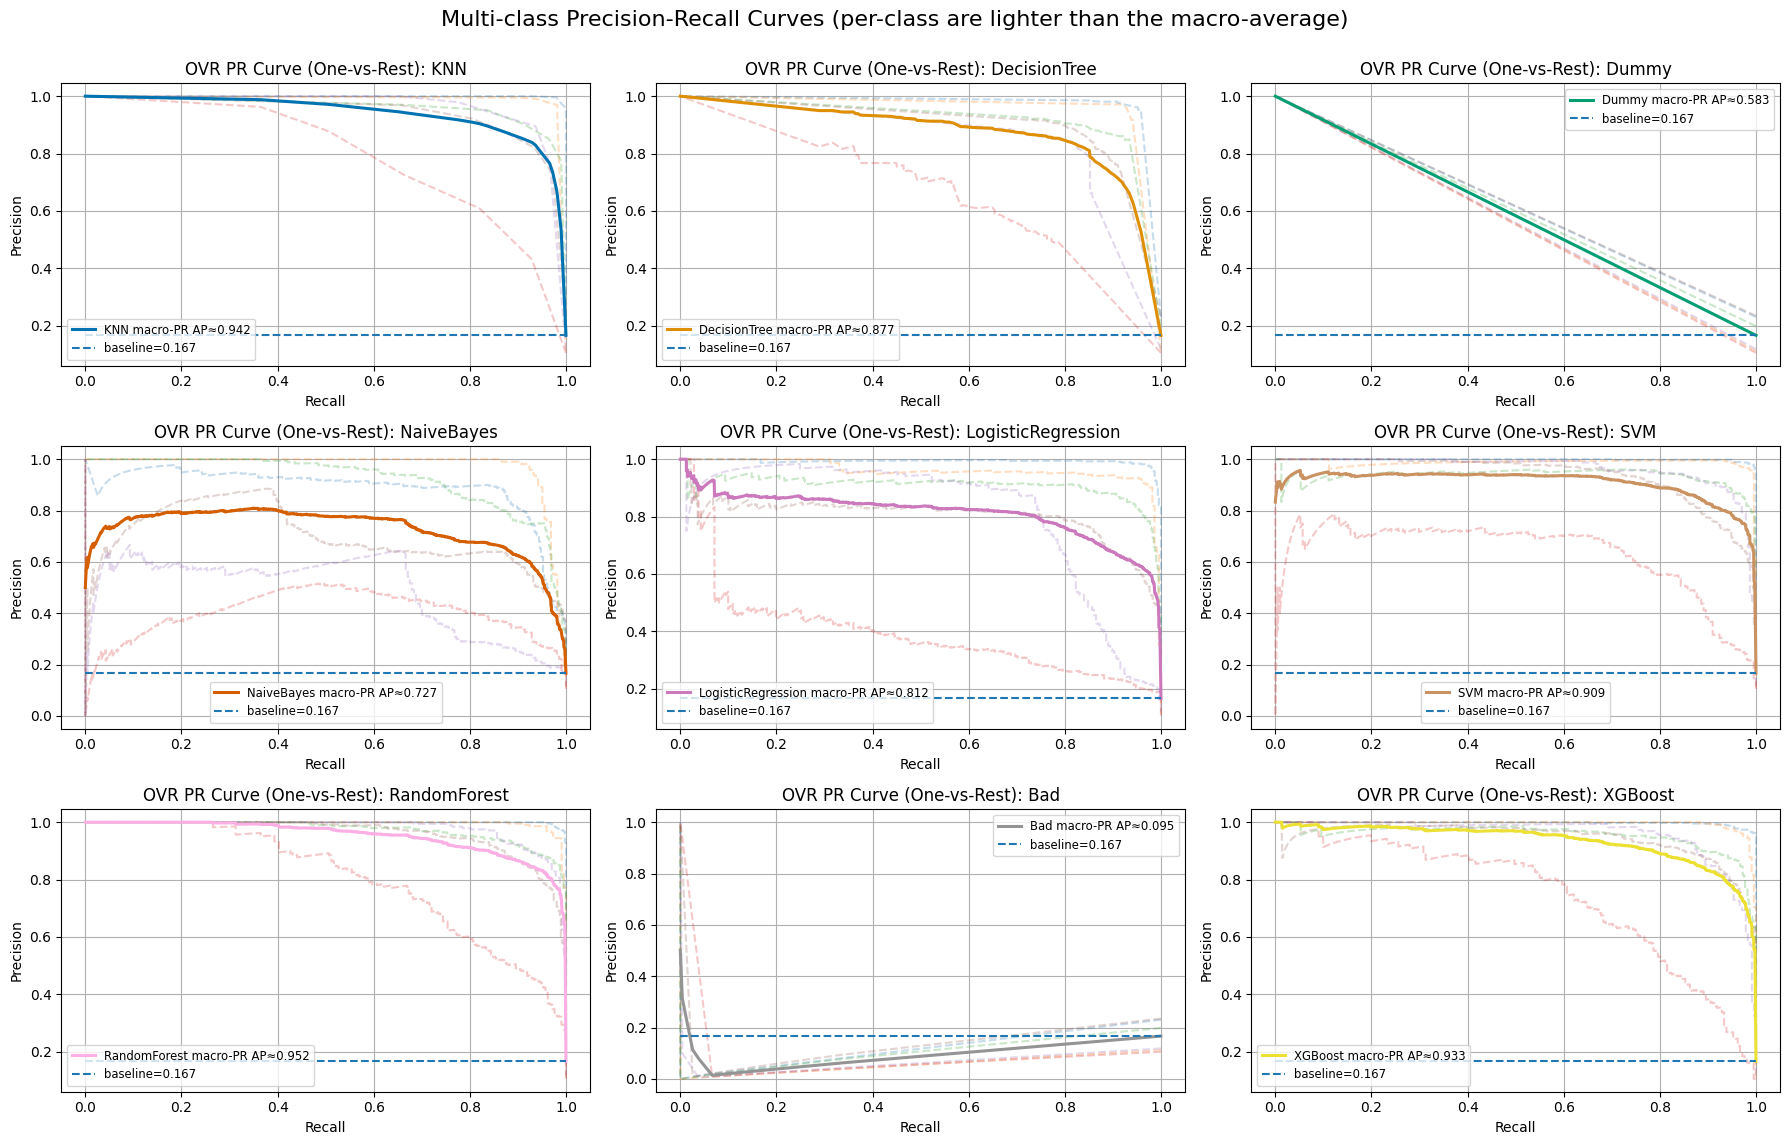

In [68]:
fig, axs = plt.subplots(3, 3, figsize=(18, 12))
axs = axs.flatten()

for idx, (name, model) in enumerate(trained_models.items()):
    ax = axs[idx]
    if hasattr(model, "predict_proba"):
        scores = model.predict_proba(X_test)
    else:
        scores = model.decision_function(X_test)
        if scores.ndim == 1:
            scores = np.vstack([-scores, scores]).T
    
    precisions = dict(); recalls = dict(); aps = dict()
    all_recall = np.unique(np.concatenate([precision_recall_curve(y_test_bin[:, i], scores[:, i])[1] for i in range(n_classes)]))
    mean_prec = np.zeros_like(all_recall)
    for i in range(n_classes):
        prec_i, rec_i, _ = precision_recall_curve(y_test_bin[:, i], scores[:, i])
        precisions[i], recalls[i] = prec_i, rec_i
        aps[i] = auc(rec_i, prec_i)  # approximate AP by trapezoid integration
        mean_prec += np.interp(all_recall, rec_i[::-1], prec_i[::-1])  # recall is increasing in rec_i[::-1]
    mean_prec /= n_classes
    macro_ap = np.mean(list(aps.values()))

    # plot per-class (light) and macro-average (thick)
    for i in range(n_classes):
        ax.plot(recalls[i], precisions[i], alpha=0.25, linestyle='--')
    ax.plot(all_recall, mean_prec, linewidth=2.2, label=f'{name} macro-PR AP≈{macro_ap:.3f}', color=colors[idx])
    # baseline: horizontal at prevalence (mean positive rate)
    prevalence = y_test_bin.mean()
    ax.hlines(prevalence, 0, 1, linestyles='dashed', label=f'baseline={prevalence:.3f}')
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_title(f'OVR PR Curve (One-vs-Rest): {name}')
    ax.legend(fontsize='small')
    ax.grid(True)


plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle("Multi-class Precision-Recall Curves (per-class are lighter than the macro-average)", fontsize=16)
plt.show()


### PRC Interpretation

**Model with the highest Average Precision(AP) across the classes**

*Random Forest*

**Analyze the behavior of the worst-performing model's PRC**

*Based on the context, we have three worst performing models*

*Bad: The worst performing model because it was intended to be. Due to the inverse results returned, the model behaves differently from what a general PR curve is supposed to be, instead having the lowest precision at a Recall of 0.2, which then begins to increase with recall, indicating that the model actually benefits by setting all points to positive.*

*Dummy: Among the (non-brownie) mentioned models, the worst performing one. Its results could be easily explained as following the expected trend line, as it is a random classifier without any knowledge of the features, which means as the threshold would change, the precision decreases linearly with increasing recall.*

*Naive Bayes: Non-dummy worst performing model. This performance might be due to the fact that the model assumes feature independence, which while allowing a good F1-score, leads to a poor learning of the space itself, which means that while the model can identify the decision regions well enough, it gets confused at the exact edges of the decision regions i.e. the decision boundaries, which means for the smaller positive class regions, it would have more chance of misclassification, as shown in its curve, where precision increases with recall to some extent, meaning as threshold decreases, i.e. more positive points are allowed, the decision boundary is expressed better, until after the plateau, which arises because different classes have different peaks of this cordial relation between precision and recall after which the precision begins to decrease with the recall. After this plateau (or peaks class-wise), more and more false positives are allowed in, leading to lower precision.*

**Why does the curve drop sharply as Recall increases for poor models?**

*For poor models, the curve showcases a sharp drop, particularly for minority class because higher recall would mean more and more points would get classified to that class. As such, with higher recall, there would be a greater number of false positives, which would drop the curve. This recall would increase with the threshold, and even at the base threshold, the best model (RandomForest) showcases a sharp drop for one of the classes, which gets quite distant from the others.*

## Part D: Final Recommendation


**Synthesis**

Ranking Table (Testing), sorted by Highest F1-Score at top:

             Model      Accuracy  F1-Score  ROC-AUC (macro)     PR-AUC (macro)
      RandomForest        0.9040  0.901377         0.990159        0.952194
               KNN        0.9010  0.900524         0.977779        0.920575
           XGBoost        0.9005  0.898898         0.983971        0.932795
               SVM        0.8910  0.886662         0.983314        0.910070
      DecisionTree        0.8510  0.850846         0.936659        0.826382
        NaiveBayes        0.8010  0.802902         0.937400        0.728161
    LogisticRegression    0.8205  0.792476         0.953972        0.812282
             Dummy        0.2305  0.086356         0.500000        0.166667
               Bad        0.0105  0.006253         0.021750        0.133013


*Based on comparision of F1-Score, ROC-AUC and PRC-AP, the Random Forest model performs best in all three criterions. However, among the other models, difference do emerge.*

*Naive Bayes has a high ROC-AUC, it suffers in f1 and more severelu in PR-AUC, which is due to the Naive Bayes modeling for the minority class allowing more points to be classified as positive, leading to an overall increase in the count of the false positives, which is captured much better by the PR-AUC score rather than the ROC-AUC, which gets inflated by the false negatives. LogisticRegression performs better in ROC-AUC than PR-AUC due to the same reason as Naive Bayes i.e. the faulty assumption about the data, which in this case is it being linear assumptions.*


*Most other models perform as expected, with KNN being slightly better in F1-score than even XGBoost and SVM, but having a lower ROC-AUC than both and PR-AUC than XGBoost, which might be because the same-class points could be closer in the space, allowing good nearest-neighbour based prediction, but giving no information about the space itself, reflected in the results.*

**Recommendation**

*Due to a high accuracy, f1-score, ROC-AUC AND PR-AUC, Random Forest is the best model. It balances both precision and recall at the default threshold, ensuring stable precision at high recalls and gives a significantly higher weightage to the correct labels.*

*If a non-brownie model is required, however, kNN is a good recommendation, as the dataset appears to have same-class neighbourhoods, allowing it to outperform models such as Naive Bayes and SVM.*

**Random Forest (brownie)/kNN (non-brownie) model is the recommendation for this case**